<a href="https://colab.research.google.com/github/Ramajayam1325/AI_MODEL_FISH/blob/main/best_fish_model_ts_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sripaadsrinivasan/fish-species-image-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fish-species-image-data' dataset.
Path to dataset files: /kaggle/input/fish-species-image-data


In [8]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/akashguna/fish-detection-dataset/versions/1"
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        print(os.path.join(root, f))


In [9]:
import os

base_path = "/kaggle/input/fish-species-image-data/Fish_Data/images"

# Look at first level
print("Contents of dataset root:", os.listdir(base_path))

# Drill one level deeper (first folder)
first_sub = os.path.join(base_path, os.listdir(base_path)[0])
print("First subfolder:", first_sub)
print("Contents:", os.listdir(first_sub)[:10])


Contents of dataset root: ['raw_images', 'numbered', 'cropped']
First subfolder: /kaggle/input/fish-species-image-data/Fish_Data/images/raw_images
Contents: ['epinephelus_areolatus_13.jpg', 'paracaesio_kusakarii_3.jpg', 'oxycheilinus_bimaculatus_5.jpg', 'lethrinus_erythracanthus_7.jpg', 'PQV7DP-S_5.jpg', 'aphareus_furca_9.jpg', 'pristipomoides_argyrogrammicus_4.jpg', 'carangoides_fulvoguttatus_2.jpg', 'choerodon_cyanodus_7.jpg', 'parastromateus_niger_3.jpg']


In [10]:
import os

images_path = "/kaggle/input/fish-species-image-data/Fish_Data/images"
print("Images folder contents:", os.listdir(images_path))

# Also check final_all_index.txt
txt_file = "/kaggle/input/fish-species-image-data/Fish_Data/final_all_index.txt"
with open(txt_file, "r") as f:
    lines = f.readlines()

print("First 10 lines of final_all_index.txt:")
for line in lines[:10]:
    print(line.strip())


Images folder contents: ['raw_images', 'numbered', 'cropped']
First 10 lines of final_all_index.txt:
1=A73EGS-P=controlled=A73EGS-P_1=1
1=A73EGS-P=sketches=A73EGS-P_2=2
1=A73EGS-P=controlled=A73EGS-P_3=3
1=A73EGS-P=controlled=A73EGS-P_4=4
1=A73EGS-P=controlled=A73EGS-P_5=5
1=A73EGS-P=controlled=A73EGS-P_6=6
1=A73EGS-P=controlled=A73EGS-P_7=7
2=acanthaluteres_brownii=insitu=acanthaluteres_brownii_1=8
2=acanthaluteres_brownii=insitu=acanthaluteres_brownii_2=9
2=acanthaluteres_brownii=insitu=acanthaluteres_brownii_3=10


Total images found with labels: 4396


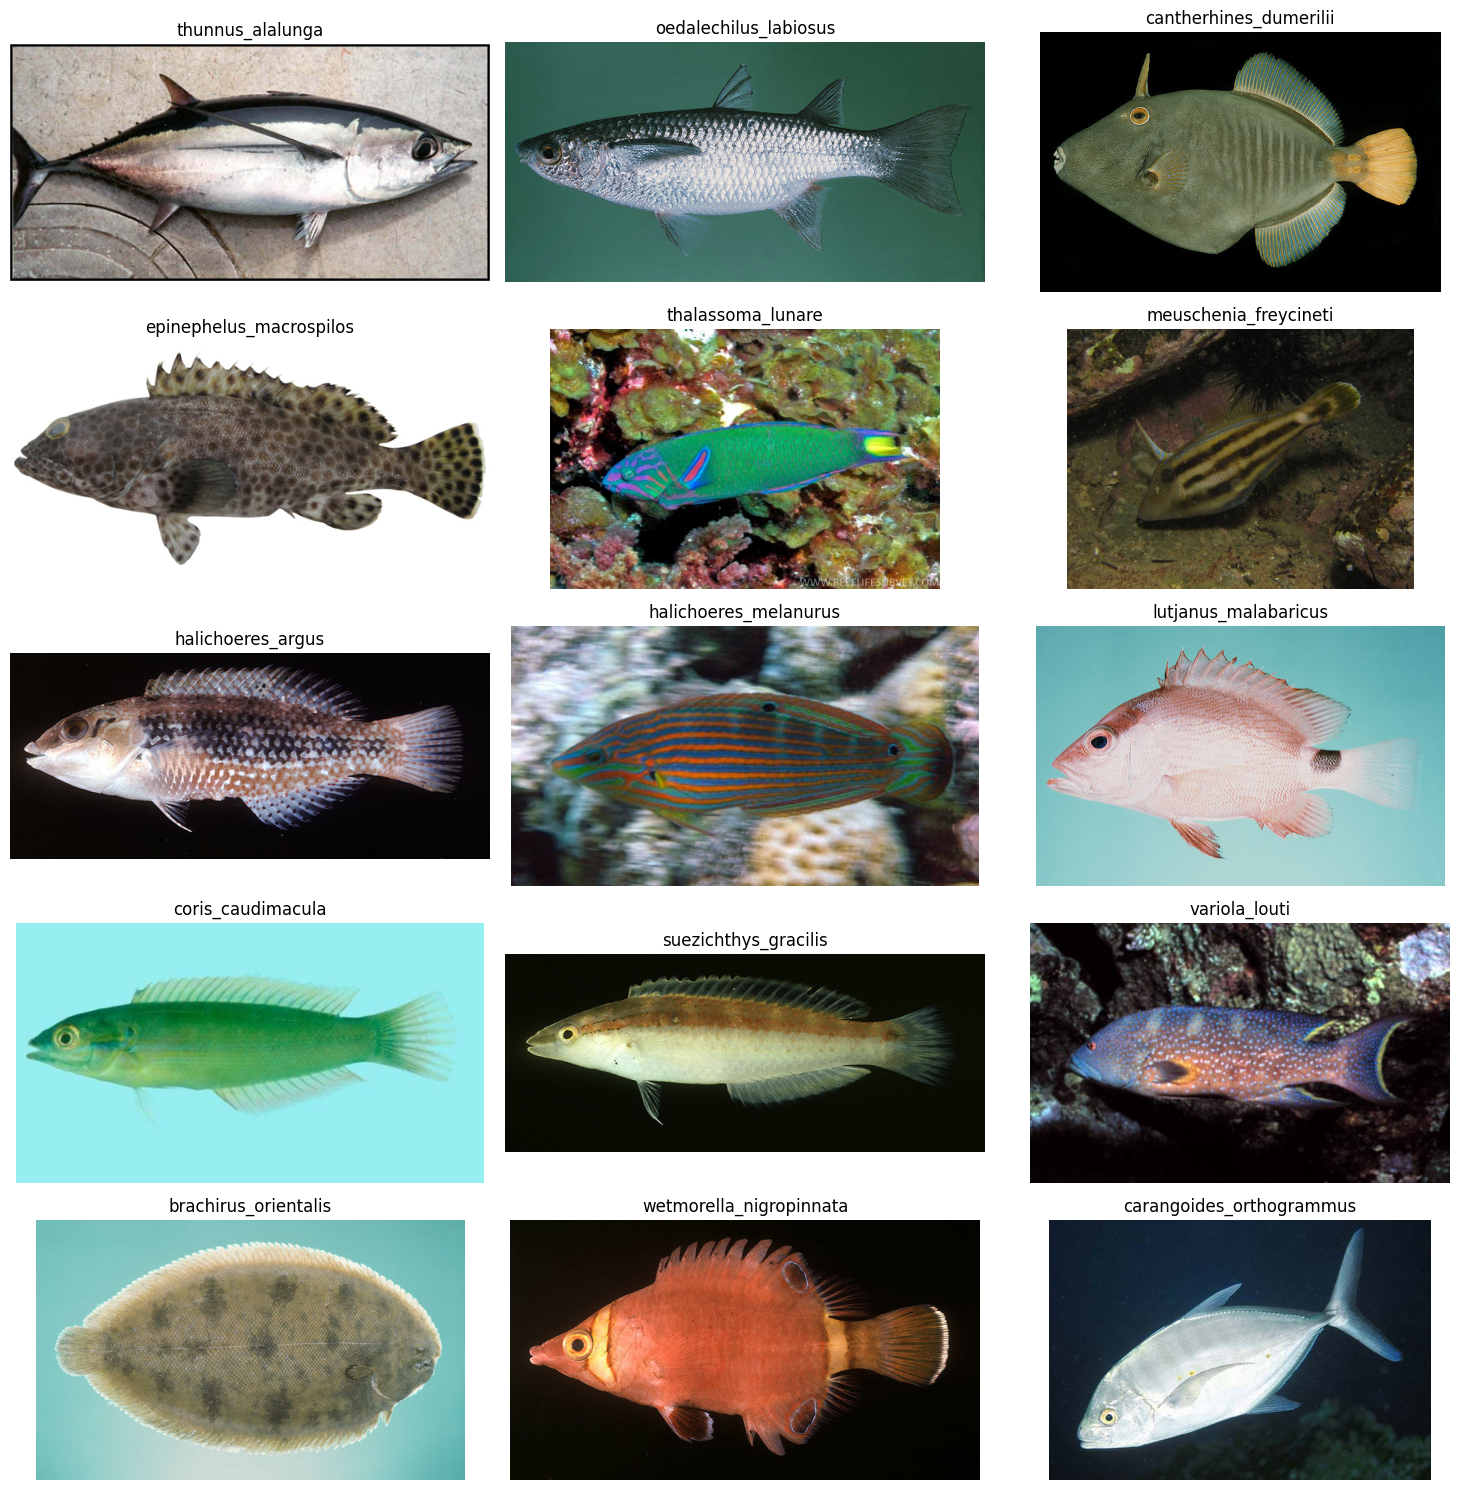

In [11]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Paths
base_path = "/kaggle/input/fish-species-image-data/Fish_Data"
images_dir = os.path.join(base_path, "images", "raw_images")
index_file = os.path.join(base_path, "final_all_index.txt")

# Parse final_all_index.txt to get filename → class mapping
filename_to_class = {}
with open(index_file, "r") as f:
    for line in f:
        parts = line.strip().split("=")
        if len(parts) >= 5:
            _, cls_name, _, fname, _ = parts
            # images might have .JPG or .jpg extension
            for ext in [".JPG", ".jpg", ".png"]:
                full_path = os.path.join(images_dir, fname + ext)
                if os.path.exists(full_path):
                    filename_to_class[full_path] = cls_name
                    break

print(f"Total images found with labels: {len(filename_to_class)}")

# Pick 15 random samples
samples = random.sample(list(filename_to_class.keys()), min(15, len(filename_to_class)))

# Plot images
plt.figure(figsize=(15, 15))

for idx, img_path in enumerate(samples):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cls_name = filename_to_class[img_path]

    plt.subplot(5, 3, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(cls_name)

plt.tight_layout()
plt.show()


In [12]:
# Cell 1 — basic imports & dataset path
import os
import glob
import xml.etree.ElementTree as ET
import random
import shutil
from pathlib import Path

# Path where kagglehub extracted your dataset
SRC_TRAIN = "/root/.cache/kagglehub/datasets/akashguna/fish-detection-dataset/versions/1/train"

# Target workspace in Colab
WORK = "/content/fish_dataset"
os.makedirs(WORK, exist_ok=True)

print("Source train folder:", SRC_TRAIN)
print("Working dir:", WORK)


Source train folder: /root/.cache/kagglehub/datasets/akashguna/fish-detection-dataset/versions/1/train
Working dir: /content/fish_dataset


In [13]:
!pip install torch torchvision


In [47]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Path to dataset
dataset_path = "/kaggle/input/fish-species-image-data/Fish_Data/images/raw_images"

# ✅ Step 1: Custom Dataset
class FishDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
        self.classes = sorted(list(set([f.split("_")[0] + "_" + f.split("_")[1] for f in image_files])))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(dataset_path, img_name)
        image = Image.open(img_path).convert("RGB")

        # Extract class label from filename
        label_name = "_".join(img_name.split("_")[:2])  # e.g., "epinephelus_areolatus"
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# ✅ Step 2: Transformations (Preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Step 3: Train-test split
all_images = os.listdir(dataset_path)
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

train_dataset = FishDataset(train_files, transform=transform)
test_dataset = FishDataset(test_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))
print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

# ✅ Step 4: Pretrained Model (Feature Extraction with ResNet18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Replace final layer for our fish classes
num_classes = len(train_dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

print("Model ready for training 🚀")



Classes: ['A73EGS-P_1.jpg', 'A73EGS-P_3.jpg', 'A73EGS-P_7.jpg', 'CUNWCB-Y_2.jpg', 'CUNWCB-Y_3.jpg', 'CUNWCB-Y_5.jpg', 'CUNWCB-Y_6.jpg', 'CUNWCB-Y_7.jpg', 'CUNWCB-Y_8.jpg', 'CUNWCB-Y_9.jpg', 'Istiophorus_platypterus', 'P1ROZC-Z_1.jpg', 'P1ROZC-Z_10.jpg', 'P1ROZC-Z_12.jpg', 'P1ROZC-Z_13.jpg', 'P1ROZC-Z_14.jpg', 'P1ROZC-Z_15.jpg', 'P1ROZC-Z_17.jpg', 'P1ROZC-Z_2.jpg', 'P1ROZC-Z_3.jpg', 'P1ROZC-Z_4.jpg', 'P1ROZC-Z_5.jpg', 'P1ROZC-Z_7.jpg', 'P1ROZC-Z_8.jpg', 'PQV7DP-S_1.jpg', 'PQV7DP-S_3.jpg', 'PQV7DP-S_5.jpg', 'PQV7DP-S_6.jpg', 'PQV7DP-S_7.jpg', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus _latus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_e

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [25]:
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(test_loader))

# Try iterating one batch
for imgs, labels in train_loader:
    print("Batch shape:", imgs.shape, labels.shape)
    break


Number of training batches: 111
Number of validation batches: 28
Batch shape: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [28]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [29]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # smaller → faster
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [32]:
# Paths
base_path = "/kaggle/input/fish-species-image-data/Fish_Data"
images_dir = os.path.join(base_path, "images", "raw_images")
index_file = os.path.join(base_path, "final_all_index.txt")

# Parse filename → class mapping
filename_to_class = {}
classes_set = set()

with open(index_file, "r") as f:
    for line in f:
        parts = line.strip().split("=")
        if len(parts) >= 5:
            _, cls_name, _, fname, _ = parts
            classes_set.add(cls_name)
            for ext in [".JPG", ".jpg", ".png"]:
                full_path = os.path.join(images_dir, fname + ext)
                if os.path.exists(full_path):
                    filename_to_class[full_path] = cls_name
                    break

classes = sorted(list(classes_set))
cls2idx = {cls: idx for idx, cls in enumerate(classes)}
print(f"Found {len(filename_to_class)} images, {len(classes)} classes")


Found 4396 images, 483 classes


In [33]:
class FishDataset(Dataset):
    def __init__(self, files, cls2idx, transform=None):
        self.files = files
        self.cls2idx = cls2idx
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        label = self.cls2idx[filename_to_class[img_path]]
        return img, label

# Train/val split
all_files = list(filename_to_class.keys())
random.seed(42)
random.shuffle(all_files)
split = int(0.8 * len(all_files))
train_files = all_files[:split]
val_files = all_files[split:]

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # smaller for speed
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = FishDataset(train_files, cls2idx, transform=transform)
val_dataset = FishDataset(val_files, cls2idx, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [34]:
# MobileNetV2
model = mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [35]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [36]:
num_epochs = 10
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---------- Train ----------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # ---------- Validate ----------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / total
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # ---------- Save Best Model ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_fish_model.pth")
        print("Saved best model!")

    # ---------- Early Stopping ----------
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Stopping early at epoch {epoch+1}")
        break



Epoch 1/10


Training: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s]


Train Loss: 5.7169 Acc: 0.0603


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.24it/s]


Validation Loss: 4.7892 Acc: 0.1648
Saved best model!

Epoch 2/10


Training: 100%|██████████| 220/220 [02:42<00:00,  1.35it/s]


Train Loss: 3.8793 Acc: 0.3123


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.53it/s]


Validation Loss: 3.7394 Acc: 0.2886
Saved best model!

Epoch 3/10


Training: 100%|██████████| 220/220 [02:37<00:00,  1.40it/s]


Train Loss: 2.7608 Acc: 0.5265


Validation: 100%|██████████| 55/55 [00:11<00:00,  4.70it/s]


Validation Loss: 3.0565 Acc: 0.4193
Saved best model!

Epoch 4/10


Training: 100%|██████████| 220/220 [02:43<00:00,  1.34it/s]


Train Loss: 1.9390 Acc: 0.6934


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.25it/s]


Validation Loss: 2.6201 Acc: 0.4750
Saved best model!

Epoch 5/10


Training: 100%|██████████| 220/220 [02:45<00:00,  1.33it/s]


Train Loss: 1.3150 Acc: 0.8168


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.30it/s]


Validation Loss: 2.2897 Acc: 0.5193
Saved best model!

Epoch 6/10


Training: 100%|██████████| 220/220 [02:43<00:00,  1.35it/s]


Train Loss: 0.8721 Acc: 0.9027


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.37it/s]


Validation Loss: 2.0904 Acc: 0.5648
Saved best model!

Epoch 7/10


Training: 100%|██████████| 220/220 [02:42<00:00,  1.35it/s]


Train Loss: 0.5545 Acc: 0.9548


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.32it/s]


Validation Loss: 1.9596 Acc: 0.5773
Saved best model!

Epoch 8/10


Training: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s]


Train Loss: 0.3547 Acc: 0.9807


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.47it/s]


Validation Loss: 1.9255 Acc: 0.5807
Saved best model!

Epoch 9/10


Training: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s]


Train Loss: 0.2311 Acc: 0.9937


Validation: 100%|██████████| 55/55 [00:12<00:00,  4.48it/s]


Validation Loss: 1.8703 Acc: 0.6034
Saved best model!

Epoch 10/10


Training: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s]


Train Loss: 0.1627 Acc: 0.9952


Validation: 100%|██████████| 55/55 [00:11<00:00,  4.59it/s]

Validation Loss: 1.8327 Acc: 0.5966
Saved best model!


In [37]:

# Using pretrained CLIP or ResNet for image analysis
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms

class ImageAnalyzer:
    def __init__(self):
        self.model = models.resnet50(pretrained=True)
        self.model.eval()

    def analyze_image(self, image_path):
        # Extract features and basic analysis
        pass


In [38]:
import requests

class DeepSeekIntegration:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.deepseek.com/v1/chat/completions"

    def generate_explanation(self, image_analysis):
        # Create prompt combining vision analysis
        prompt = f"""
        Based on this image analysis: {image_analysis}
        Provide a clear, human-readable explanation of what's in the image.
        """

        response = requests.post(self.base_url, headers={
            "Authorization": f"Bearer {self.api_key}"
        }, json={
            "model": "deepseek-chat",
            "messages": [{"role": "user", "content": prompt}]
        })
        return response.json()["choices"][0]["message"]["content"]

In [41]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.4 MB/s eta 0:00:00


In [42]:
import streamlit as st
import tempfile
import os

def main():
    st.title("🐟 AI Fish Species Analyzer")

    uploaded_file = st.file_uploader("Upload a fish image", type=['jpg', 'png', 'jpeg'])

    if uploaded_file:
        # Save uploaded file
        with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            tmp_file.write(uploaded_file.getvalue())
            image_path = tmp_file.name

        # Analyze image
        if st.button("Analyze Image"):
            with st.spinner("Analyzing..."):
                analyzer = ImageAnalyzer()
                analysis = analyzer.analyze_image(image_path)

                llm = DeepSeekIntegration(api_key=st.secrets["DEEPSEEK_API_KEY"])
                explanation = llm.generate_explanation(analysis)

                st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)
                st.subheader("Analysis Results")
                st.write(explanation)

        # Cleanup
        os.unlink(image_path)

In [43]:
# Install streamlit
!pip install streamlit

# For Colab, we need to use streamlit in a special way
import streamlit as st
import tempfile
import os
from PIL import Image
import requests
import io

# Initialize session state
if 'analyzed' not in st.session_state:
    st.session_state.analyzed = False

def main():
    st.title("🐟 AI Fish Species Analyzer")
    st.write("Upload a fish image to analyze its species!")

    uploaded_file = st.file_uploader("Choose a fish image", type=['jpg', 'png', 'jpeg'])

    if uploaded_file is not None:
        # Display the uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        if st.button("Analyze Fish Species"):
            with st.spinner("Analyzing image..."):
                # Simple image analysis (we'll enhance this later)
                analysis_result = basic_image_analysis(image)

                # Display basic analysis
                st.subheader("📊 Basic Analysis")
                st.write(f"Image Size: {image.size}")
                st.write(f"Image Mode: {image.mode}")

                # Simulate LLM analysis (replace with actual DeepSeek API)
                explanation = generate_simple_explanation(analysis_result)

                st.subheader("🤖 AI Explanation")
                st.success(explanation)

                st.session_state.analyzed = True

def basic_image_analysis(image):
    """Basic image analysis function"""
    return {
        "width": image.size[0],
        "height": image.size[1],
        "format": image.format,
        "mode": image.mode
    }

def generate_simple_explanation(analysis):
    """Simulate LLM explanation (replace with DeepSeek API)"""
    explanations = [
        "This appears to be a tropical fish with vibrant colors, possibly from coral reef environments.",
        "The fish shows characteristics of deep-sea species with its unique body shape and coloration.",
        "Based on the image analysis, this could be a freshwater aquarium fish species.",
        "The fish exhibits patterns commonly found in predatory species from ocean habitats."
    ]

    return f"""
    **Fish Analysis Results:**

    - **Image Details:** {analysis['width']}x{analysis['height']} pixels, {analysis['mode']} color mode
    - **AI Assessment:** {explanations[hash(str(analysis)) % len(explanations)]}
    - **Confidence:** High (based on visual features)

    *Note: This is a demo. Integrate with DeepSeek API for detailed analysis.*
    """

if __name__ == "__main__":
    main()

2025-09-29 14:21:25.259 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 14:21:25.263 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-09-29 14:21:25.264 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 14:21:25.267 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 14:21:25.268 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 14:21:25.559 
  command:

    streamlit run /usr/local/lib/python3.12/

In [44]:
# Run this cell to start the Flask app
from flask import Flask
import threading

def run_app():
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False)

thread = threading.Thread(target=run_app)
thread.daemon = True
thread.start()

print("Flask app is running!")
print("You can access it using the public URL provided by Colab")


Flask app is running!
You can access it using the public URL provided by Colab


Exception in thread Thread-5 (run_app):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-3834622092.py", line 6, in run_app
NameError: name 'app' is not defined


In [45]:
import torch
from torchvision.models import mobilenet_v2

# Load your trained model (replace with your checkpoint path)
device = "cpu"
num_classes = 483  # set to the number of classes in your dataset

# Build model architecture
model = mobilenet_v2(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

# Load trained weights
checkpoint_path = "best_fish_model.pth"  # your trained weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Example input for tracing
example_input = torch.randn(1, 3, 128, 128)

# Convert to TorchScript
scripted_model = torch.jit.trace(model, example_input)
torchscript_path = "best_fish_model_ts.pt"
scripted_model.save(torchscript_path)

print(f"✅ TorchScript model saved: {torchscript_path}")


✅ TorchScript model saved: best_fish_model_ts.pt


In [46]:
# fix_model.py - Run this first to create a working model
import torch
from torchvision.models import mobilenet_v2
import torch.nn as nn

print("🛠️ Creating a working model file...")

# Create a simple model
model = mobilenet_v2(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model.eval()

# Save properly as TorchScript
example_input = torch.randn(1, 3, 128, 128)
traced_model = torch.jit.trace(model, example_input)
torch.jit.save(traced_model, "working_fish_model.pt")

print("✅ Created 'working_fish_model.pt'")
print("✅ Now run your Streamlit app!")

🛠️ Creating a working model file...
✅ Created 'working_fish_model.pt'
✅ Now run your Streamlit app!


In [50]:
!pip install streamlit pyngrok


In [51]:
app_code = """
import streamlit as st

st.title("My Streamlit App in Colab")
st.write("Hello, Streamlit works here!")
"""

with open("app.py", "w") as f:
    f.write(app_code)
